# GANs for Generating Images of Dogs

In this study, a GAN will be trained in an attempt to generate realistic images of dogs. This is an example of an unsupervised task in deep learning.

In a Generative Adversarial Network (GAN), a generator neural network is fed some kind of input and is tasked with converting that input into a counterfit output (e.g. a dog image). A discriminator neural network is then tasked with correctly identifying counterfit items. After the discriminator has been trained, it is then used to help the generator produce more realistic output and the cycle continues until the generator is able to output images of a sufficient quality.

In [ ]:
pip install xmltodict

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import save_img
from matplotlib import image as showimg
import xmltodict
import PIL

## Data Description

The images used to train the GAN in this study can be downloaded from [kaggle](https://www.kaggle.com/competitions/generative-dog-images/data). That data, in turn, was copied from the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). This dataset contains 20,580 JPG images of dogs belonging to 120 different breeds. The images are of various sizes and encoded with three color channels (RGB).

There is an accompanying <code>Annotations</code> directory that contains .xml files with additional information about the dog images (e.g. bounding box, breed, pose, etc.). This information will be useful in the data cleaning procedure. 

In [ ]:
!mkdir /root/.kaggle
!cp kaggle.json ../root/.kaggle
!ls ../root/.kaggle
!kaggle competitions download -c generative-dog-images
!unzip -q generative-dog-images.zip -d generative-dog-images

kaggle.json
100% 743M/744M [00:07<00:00, 108MB/s]
100% 744M/744M [00:07<00:00, 106MB/s]


In [ ]:
!unzip -q generative-dog-images/all-dogs.zip -d generative-dog-images

In [ ]:
!unzip -q generative-dog-images/Annotation.zip -d generative-dog-images

In [ ]:
!mkdir dogs-xml
!cp generative-dog-images/Annotation/*/* dogs-xml

## Exploratory Data Analysis

Let us take a look at the data and get a good understanding of it. 

In [ ]:
def get_imgs(path, batch_size):
    return tf.keras.preprocessing.image_dataset_from_directory(
    path, labels=None, batch_size=batch_size, seed=123)

In [ ]:
samp_dogs = next(iter(get_imgs("generative-dog-images/all-dogs", 5)))

Found 20579 files belonging to 1 classes.


Here is a small sampling of raw dog images. There are many different objects depicted in these images. Therefore, it is important that that we crop these images around the subject of interest.

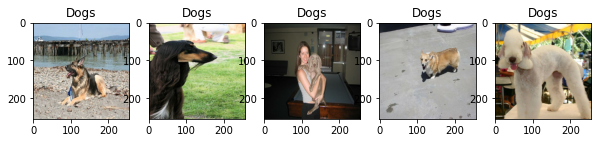

In [ ]:
plt.figure(figsize=(10,10))
for (i,img) in enumerate(samp_dogs):
  plt.subplot(1, 5, i+1)
  plt.title("Dogs")
  plt.imshow(img / 255.)

The code cell below converts the information contained in the <code>XML</code> files in the <code>Annotations</code> folder into a dataframe, which is much easier to work with. Difficult images will be excluded.

In [ ]:
dogs_frame = pd.DataFrame(columns=["filename", "pose", "difficult", "name", "xmin", "ymin", "xmax", "ymax"])

for file in os.listdir("dogs-xml"):
  path = "dogs-xml/{}".format(file)

  with open(path, 'r', encoding='utf-8') as file:
    xml_file = file.read()

  xml_dict = xmltodict.parse(xml_file)

  row_dict = {}

  row_dict['filename'] = "{}.jpg".format(xml_dict['annotation']['filename'])

  obj =  xml_dict['annotation']['object']
  if type(obj) == type([]):
    obj = obj[0]

  row_dict['pose'] = obj['pose']
  row_dict['difficult'] = obj['difficult']
  row_dict['name'] =  obj['name']

  box = obj['bndbox']
  row_dict['xmin'] = box['xmin']
  row_dict['ymin'] = box['ymin']
  row_dict['xmax'] = box['xmax']
  row_dict['ymax'] = box['ymax']


  if row_dict['difficult'] == '0':
    dogs_frame = dogs_frame.append(row_dict, ignore_index=True)

Below is a bar chart showing the counts for each of the 120 dog breeds represented in the dataset. It appears that some breeds are represented more than others. This may make the GAN prone to mode collapse.

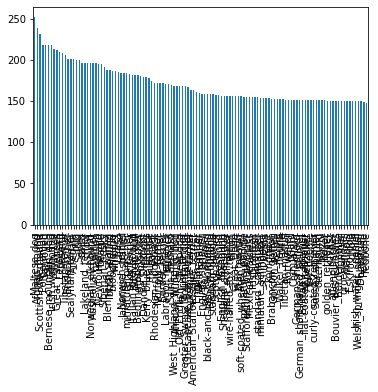

In [ ]:
dogs_frame["name"].value_counts().plot.bar()

### Data Cleaning and Transformation

The images, as they are now, are not in an ideal format. The code below crops the images around the dog depicted and resizes the resulting image into a 64x64 pixel image that is easier for the the model to work with. The cropping step is important because many of these images depict objects other than dogs (e.g. humans).

In [ ]:
!mkdir dogs
!rm dogs/*.jpg
for (i,row) in dogs_frame.iterrows():
  file = "generative-dog-images/all-dogs/{}".format(row['filename'])

  try:
    img = tf.keras.preprocessing.image.load_img(file)
  except:
    continue

  box = [int(row['xmin']) , int(row['ymin']), int(row['xmax']), int(row['ymax'])]
  crop = img.crop(box = box)
  crop = crop.resize(
      (64, 64), PIL.Image.ANTIALIAS
  )
  im = array_to_img(crop, dtype = "float32")

  #if you don't want distortions, uncomment the following code
  """  back = PIL.Image.new('RGB', (64, 64), (0, 0, 0, 0))

    w = box[2] - box[0]
    h = box[3] - box[1]

    scale = 64 / max(w,h)
    w = int(w * scale)
    h = int(h * scale)

    left = (64 - w) // 2
    top = (64 - h) // 2
    back.paste(im, (left, top))
  """
  #plt.imshow(im)
  #plt.show()

  saveLoc = "dogs/{}".format(row['filename'])
  im.save(saveLoc)

mkdir: cannot create directory ‘dogs’: File exists
rm: cannot remove 'dogs/*.jpg': No such file or directory


In [ ]:
#lets store these in a zip file so we dont have repeat this procedure all the time
!ls dogs | wc -l

!cp dogs/*.jpg .

!zip dogs.zip *.jpg

!rm *.jpg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q dogs.zip -d dogs

It looks like the cropping procedure was a success, though some of the images are a little distorted. It is possible to generate undistorted images using padding, but I have found that this impacts model performance.

Found 19956 files belonging to 1 classes.


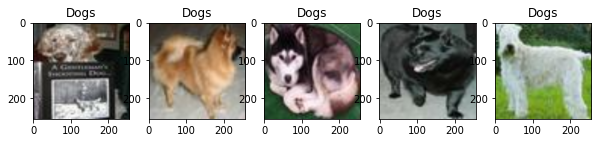

In [ ]:
samp_dogs = next(iter(get_imgs("dogs", 5)))
plt.figure(figsize=(10,10))
for (i,img) in enumerate(samp_dogs):
  plt.subplot(1, 5, i+1)
  plt.title("Dogs")
  plt.imshow(img / 255.)

It is generally good practice to standardize GAN training images to have color channel values between -1 and 1, which is the range of the hyperbolic tangent output activation function used in the generator. 

Data augmentation can add some generalizability to a model. Therefore, the images will be randomly flipped along the vertical axis.

In [ ]:
def preprocess_train_image(img):
  img = tf.image.resize(img, (64, 64))
  img = tf.image.random_flip_left_right(img)
  img = normalize_img(img)
  return img

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

dogs = get_imgs("dogs", 300).map(preprocess_train_image)

Found 19956 files belonging to 1 classes.


##Model Architecture

A GAN requires two models : an image generator and a discriminator (classifier). The generator takes a random feature vector and transforms it into an image. The discriminator takes as input both fake, generated images and real images (i.e. dogs). These two models compete in a zero-sum game: the generator is incentivized to fool the discriminator with fake images. Conversely, the discriminator is incentivized to accurately differentiate between what is real and fake.

In this study, a GAN will be trained using two different loss functions (which can be considered hyperparameters): Binary Cross Entropy (BCE) and Wasserstein loss. BCE is the standard loss function to use in a GAN. Wasserstein loss is an experimental loss function that is claimed to give stability to the training process. In addition, it is also claimed to prevent mode collapse, which is when the GAN can only generate one class of images (e.g. can only make black labradors). In this situation, it would be ideal if the GAN could generate images of all dog breeds represented in the dataset.

### Discriminator

Below is the implementation of the discriminator, which is a basic convolutional neural network. Wasserstein loss requires that the weights of the discriminator be clipped, which is the reason for the inclusion of the clipping constraint. In addition, the output activation function should be linear if using the Wasserstein technique.

In [ ]:
class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}


def build_disc(name, wasser=False):
	input = tf.keras.Input((64, 64, 3))

	const = None
	if wasser:
		const = ClipConstraint(0.01)


	x = keras.layers.Conv2D(256, 5, 2, kernel_constraint=const)(input)
	x = keras.layers.LeakyReLU()(x)
	x = keras.layers.Dropout(0.1)(x)

	x = keras.layers.Conv2D(128, 5, 2, kernel_constraint=const)(x)
	x = keras.layers.LeakyReLU()(x)
	x = keras.layers.Dropout(0.1)(x)

	activ = "sigmoid"
	if wasser:
		activ = "linear"
	x = keras.layers.Conv2D(1, 5, 2, activation=activ, kernel_constraint=const)(x)
	x = keras.layers.AveragePooling2D(5)(x)

	out = keras.layers.Flatten()(x)

	disc = tf.keras.Model(inputs=input, outputs=out, name = name)
	return disc
build_disc("discriminator").summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 256)       19456     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 256)       0         
                                                                 
 dropout (Dropout)           (None, 30, 30, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       819328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 13, 13, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 128)     

### Generator

Below is a generator neural network. It takes as input a random vector of size 256, resizes it into an image and upsamples it into an image of size 64 x 64, including color channels.

In [ ]:
def build_gen(name):
  input = tf.keras.Input(256)

  x = keras.layers.Reshape((8, 8, 4))(input)
  
  x = keras.layers.Conv2DTranspose(512, 5, strides=2, use_bias=False,padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)


  x = keras.layers.Conv2DTranspose(256, 5, strides=2, use_bias=False,padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)


  x = keras.layers.Conv2DTranspose(16, 3, strides=2, use_bias=False,padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)


  out = keras.layers.Conv2DTranspose(3, 5, use_bias=False,padding="same", activation="tanh")(x)

  return keras.Model(input, out)

build_gen("generator").summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 4)           0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      51200     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 512)      2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      327680

The following is the code that facilitates model training. Included are definitions of the two loss functions, RMSProp optimization functions, and a tensorflow function  that handles gradient updates. The BCE model is trained for 100 epochs. The Wasserstein model is trained for 20. When training a Wasserstein model, the discriminator must be updated more often than the generator. Therefore, it takes longer to train than a standard GAN.

In [ ]:
wasser = True
epochs = 20
numDiscTrials = 1
if wasser:
  numDiscTrials = 3

discriminator = build_disc("disc", wasser)
generator = build_gen("gen")

def was_loss():
  def discriminator_loss(real, fake):
    real_loss = tf.reduce_mean( tf.ones_like(len(real), dtype=tf.float32) * real)
    fake_loss = tf.reduce_mean(tf.ones_like(len(fake), dtype=tf.float32) * fake)

    return 0.5*(fake_loss - real_loss)

  def generator_loss(fake):
    return -1. * tf.reduce_mean(tf.ones_like(len(fake), dtype=tf.float32) * fake)

  return discriminator_loss, generator_loss

def reg_loss():
  loss_obj = tf.keras.losses.BinaryCrossentropy()
  
  def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

  def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

  return discriminator_loss, generator_loss

discriminator_loss, generator_loss = reg_loss()
if wasser:
  discriminator_loss, generator_loss = was_loss()

generator_optimizer = tf.keras.optimizers.RMSprop(5e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-4)


@tf.function
def train_step(images, batch_size, noise_dim):
    # change global dataframe with loss
    global loss
    
    for i in range(0, numDiscTrials):
      noise = tf.random.normal([batch_size, noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          generated_images = generator(noise, training=True)

          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          disc_loss = discriminator_loss(real_output, fake_output)
                  

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss)


for epoc in range(0, epochs):
  dog_it = iter(dogs)

  oldX = None
  oldY = None
  BATCH_SIZE = 300
  noise_dim =  256
  for i in range(0, 19956   // BATCH_SIZE + 1):
    print("Epoc {}, Iter {}".format(epoc+1, i+1))
    dog_batch = next(dog_it)
    gen_loss, disc_loss = train_step(dog_batch, BATCH_SIZE, noise_dim)

    print("Generator loss : {}, Discriminator loss: {}".format(gen_loss, disc_loss))
    if i  == 0:
      noise = tf.random.normal([1, noise_dim])
      gen_imgs = generator.predict(noise)
      samp_img = gen_imgs[0]
      im = array_to_img(samp_img, dtype = "float32")
      plt.imshow(im)
      plt.show()

      plt.imshow(array_to_img(dog_batch[0]))
      plt.show()



## Results and Analysis

Below are some sample images produced by the GAN using a standard Binary Cross Entropy loss function. These generated images don't exactly look like dogs. However, it appears that the model was able to learn some textures of the dogs' fur. Some colors appear to be more represented than others, which might be indicative of mode collapse - though the images are all different from one another, strictly speaking.

If given a longer amount of time to train, I believe that the generator will be able to create more realistic images.

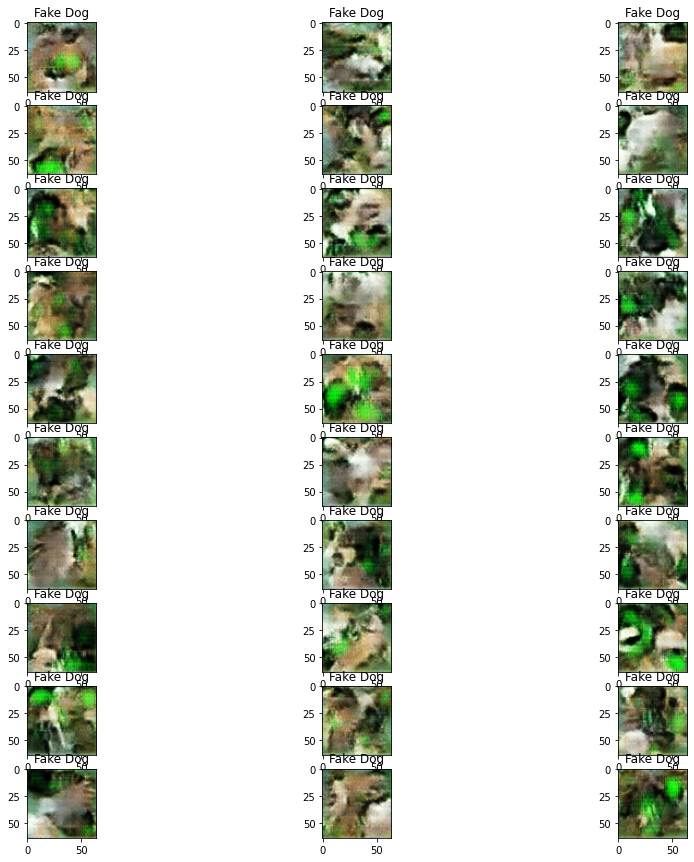

In [ ]:
fakes = generator.predict(tf.random.normal([30, noise_dim]))

plt.figure(figsize=(15,15))
for (i,img) in enumerate(fakes):
  plt.subplot(10, 3, i+1)
  plt.title("Fake Dog")
  plt.imshow(array_to_img(img))

Below are some sample images produced by the GAN using Wasserstein loss. These images are of comparable quality (if not better) than the images produced by the previous model. These images were generated over the course of fewer epochs, though training per epoch was longer. There also seems to be more diversity in the content of the images, which is a claimed feature of this type of GAN. Additionally, this model appeared to have learned some structures associate with dogs (e.g. snout, eyes, nose, paws, ears).

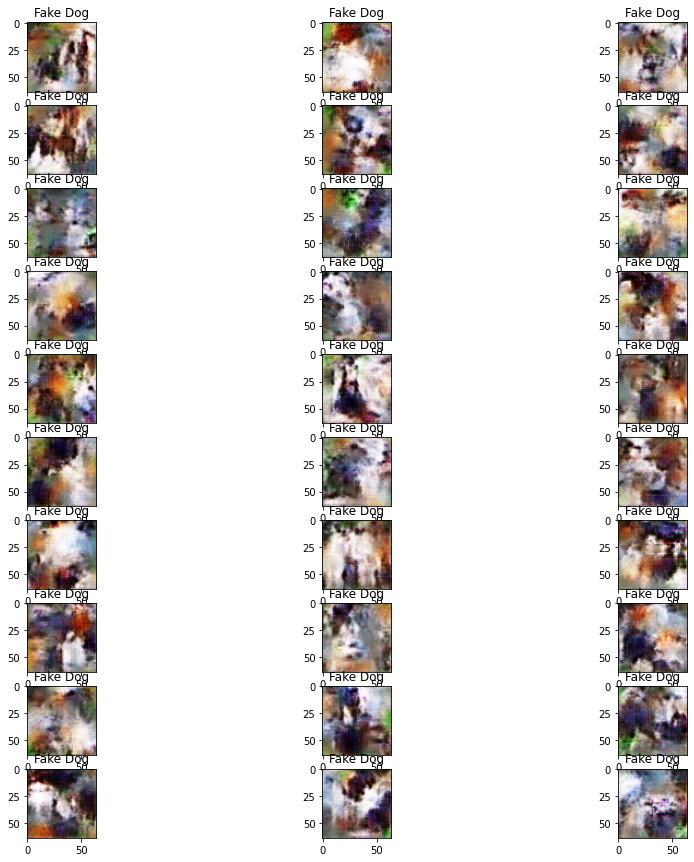

In [ ]:
fakes = generator.predict(tf.random.normal([30, noise_dim]))

plt.figure(figsize=(15,15))
for (i,img) in enumerate(fakes):
  plt.subplot(10, 3, i+1)
  plt.title("Fake Dog")
  plt.imshow(array_to_img(img))

## Conclusion

Though I was not able to produce perfect dog images, I believe that this study was a success. I believe that better results can be achieved by training a model for a longer duration of epochs. The generator and discriminator models have simple architectures, but these should be sufficient.

The Wasserstein GAN shows promising results. It was able to generate better quality images more efficiently than the standard GAN - in fewer epochs. However, the time to train per epoch is higher. This is because the discriminator must be updated more often than the generator. In this case 3:1. 

I believe that this improved performance is due to the stability of the Wasserstein loss function. I noticed that the generator and discriminator losses did not functuate as wildly compared to the standard BCE model.